<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-data-science-eleicoes/blob/master/apura%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 importações de bibliotecas e recursos

In [1]:
import pandas as pd
import numpy as np
import requests
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import cmath

# 2 funções para fazer as devidas requisições na api

In [3]:
def getDeputadoEstadualUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0007-e000546-r.json'

def getPresidentUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/544/dados-simplificados/{uf}/{uf}-c0001-e000544-r.json'

def getGovernadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0003-e000546-r.json'

def getDeputadoFederalUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0006-e000546-r.json'

def getSenadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0005-e000546-r.json'

gets= [getPresidentUrl, getSenadorUrl, getDeputadoFederalUrl, getDeputadoEstadualUrl, getGovernadorUrl]
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

# Criação do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

In [4]:
def takeData(url):
  re=requests.get(url).json()
  candidatos = re['cand']

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)
  
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)
  return(df)

In [5]:
def getAllDataByUf(uf):
  info = {}
  for index, category in enumerate(categoryKeys):
    try:
      info[category] = takeData(gets[index](uf))
    except:
      if uf == 'df':
        info[category] = 'df não tem prefeito'
      else:
        info[category] = 'this is brasil'
  return info

In [7]:
electionsData = {}
electionsData['br'] = getAllDataByUf('br')
for i, uf in  enumerate(brasil_ufs):
  electionsData[uf] = getAllDataByUf(uf)

# Os Graficos Começam daqui pra baixo

In [6]:
def getDiffBetweenJairNine(uf):
  usedData = electionsData[uf]['Presidente'][:2].values
  #print(usedData)
  bolsonaroScore = list(filter(lambda x: x[0]== 'JAIR BOLSONARO',usedData))[0][4]
  nineScore = list(filter(lambda x: x[0]== 'LULA',usedData))[0][4]
  result = float(format(abs(bolsonaroScore - nineScore),'.2f'))
  if bolsonaroScore > nineScore:
    return [result,'tab:green']
  else:
    return [result, 'tab:red']

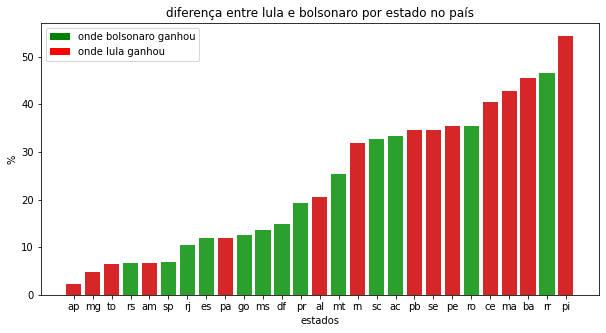

In [8]:
ordened_ufs = sorted(brasil_ufs,key=lambda uf: getDiffBetweenJairNine(uf)[0])
fig, ax = plt.subplots()

counts = (list(map(lambda uf : getDiffBetweenJairNine(uf)[0],ordened_ufs)))
bar_colors = list(map(lambda uf : getDiffBetweenJairNine(uf)[1],ordened_ufs))
fig.set_size_inches(10,5)
ax.bar(ordened_ufs, counts, color = bar_colors)
ax.bar([0], [0], color = 'green', label='onde bolsonaro ganhou') #metodo para conseguir colocar a legenda
ax.bar([0 ],[0 ], color = 'red', label='onde lula ganhou')
ax.set_ylabel('%')
ax.set_xlabel('estados')
ax.set_title('diferença entre lula e bolsonaro por estado no país')
ax.legend()

plt.show()

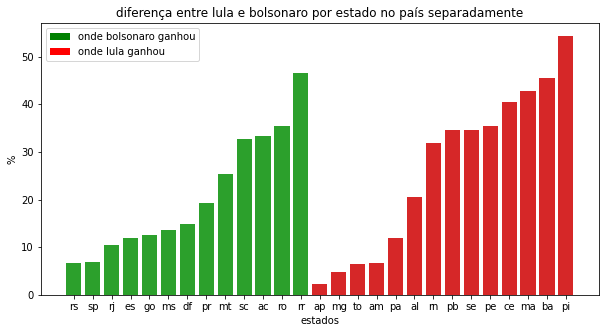

In [9]:
def separeLulaBolso(uf):
  acrecimo = 0 if getDiffBetweenJairNine(uf)[1] ==  'tab:green' else 100
  return getDiffBetweenJairNine(uf)[0] + acrecimo

ordened_ufs = sorted(brasil_ufs,key=separeLulaBolso)

counts = (list(map(lambda uf : getDiffBetweenJairNine(uf)[0],ordened_ufs)))
bar_colors = list(map(lambda uf : getDiffBetweenJairNine(uf)[1],ordened_ufs))
fig, ax = plt.subplots()
ax.bar(ordened_ufs, counts, color = bar_colors)
ax.bar([0], [0], color = 'green', label='onde bolsonaro ganhou') #metodo para conseguir colocar a legenda
ax.bar([0 ],[0 ], color = 'red', label='onde lula ganhou')
# bar_colors = list(map(lambda uf : getDiffBetweenJairNine(uf)[1],ordened_ufs))
fig.set_size_inches(10,5)
ax.set_ylabel('%')
ax.set_xlabel('estados')
ax.set_title('diferença entre lula e bolsonaro por estado no país separadamente')
ax.legend()

plt.show()